# 実験Ⅳ－１　ラッソ回帰モデル

1. サンプルデータの読み込み
1. 線形単回帰の実行
1. ラッソ回帰の実行



In [11]:
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定


## Google Colaboratory でファイルを読み込む

以下の方法があります。

1. ファイルをアップロードする
1. URL を指定する

In [12]:
# ファイルをアップロードする
#from google.colab import files
#uploaded_file = files.upload()
#file_name = next(iter(uploaded_file))
#print(file_name)

# URLを指定する
# filename = 'https://...'

In [13]:

#観測データのファイル
filename = './data/sample01_03.txt'

#観測データ（空白区切り）の読み込み
dataset = pd.read_csv(filename, delim_whitespace=True)
display(dataset)

#観測データ数
nSamples = len(dataset)

,NANOMETERS,TRANSMITTANCE
0,2500.0,76.712
1,2498.0,75.432
2,2496.0,76.729
3,2494.0,75.568
4,2492.0,75.276
...,...,...
1151,198.0,37.655
1152,196.0,37.463
1153,194.0,37.523
1154,192.0,40.449


In [14]:
# 説明変数の設定
x = dataset.iloc[:,0].values.reshape(-1,1) 
#display(x)

# 目的変数の設定
y = dataset.iloc[:,1].values.reshape(-1,1)
#display(y)

## 観測データの散布図


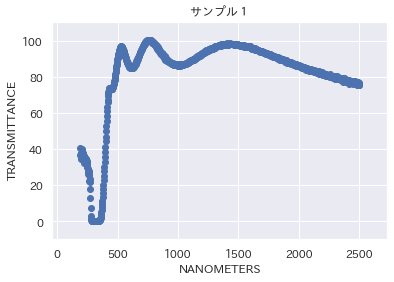

In [15]:
# 散布図の範囲情報の抽出
minx = np.min(x)
maxx = np.max(x)
rx = maxx-minx
cx = 0.5*rx
miny = np.min(y)
maxy = np.max(y)
ry = maxy-miny
cy = 0.5*ry

# 散布図の表示
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.set_title("サンプル１")
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()

## 線形単回帰の実行

In [16]:
from sklearn.linear_model import LinearRegression

# 線形単回帰のインスタンス生成
regu = LinearRegression()

# 線形単回帰分析
regu.fit(x,y)

LinearRegression()

β0 = 65.75 
β1 =  0.01 


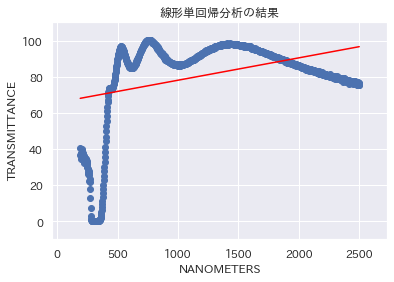

In [17]:
# 推定結果
beta0 = regu.intercept_[0]
beta1 = regu.coef_[0][0]
print("β0 = {0:5.2f} ".format(beta0))
print("β1 = {0:5.2f} ".format(beta1))

# 回帰直線をプロット
fig, ax = plt.subplots()
xfit = np.linspace(minx,maxx,nSamples).reshape(-1,1)
yfit = regu.predict(xfit)
ax.scatter(x,y)
ax.plot(xfit,yfit, color = 'red')
ax.set_title("線形単回帰分析の結果")
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()

## 多項式単回帰モデルの次数の選択


deg = 1: AIC = 1.03e+04 
deg = 2: AIC = 9.40e+03 
deg = 3: AIC = 9.01e+03 
deg = 4: AIC = 8.87e+03 
deg = 5: AIC = 8.85e+03 
deg = 6: AIC = 9.49e+03 
deg = 7: AIC = 9.80e+03 
deg = 8: AIC = 9.99e+03 
deg = 9: AIC = 1.01e+04 
deg = 10: AIC = 1.02e+04 
deg = 11: AIC = 1.03e+04 
deg = 12: AIC = 1.03e+04 
deg = 13: AIC = 1.03e+04 
deg = 14: AIC = 1.04e+04 
deg = 15: AIC = 1.04e+04 
deg = 16: AIC = 1.04e+04 
deg = 17: AIC = 1.04e+04 
deg = 18: AIC = 1.05e+04 
deg = 19: AIC = 1.05e+04 
deg = 20: AIC = 1.05e+04 
deg = 21: AIC = 1.05e+04 
deg = 22: AIC = 1.05e+04 
deg = 23: AIC = 1.05e+04 
deg = 24: AIC = 1.05e+04 
deg = 25: AIC = 1.05e+04 
deg = 26: AIC = 1.05e+04 
deg = 27: AIC = 1.05e+04 
deg = 28: AIC = 1.05e+04 
deg = 29: AIC = 1.05e+04 
deg = 30: AIC = 1.05e+04 


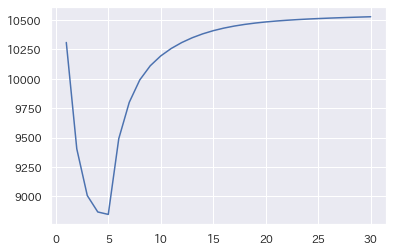

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

maxdeg = 30
deg = np.zeros(maxdeg,dtype=int)
aic = np.zeros(maxdeg)
regp = [ [] for idx in range(maxdeg) ]
for idx in range(maxdeg):
    deg[idx] = idx+1
    # 多項式単回帰のインスタンス生成
    regp[idx] = make_pipeline(PolynomialFeatures(degree=deg[idx]),
                         LinearRegression())
    # 多項式単回帰分析
    regp[idx].fit(x,y)

    # AIC
    ypred = regp[idx].predict(x)
    mse = mean_squared_error(y,ypred)
    aic[idx] = nSamples*np.log(2*np.pi*mse)+nSamples+2*(deg[idx]+2)
    print("deg = {0:d}: AIC = {1:5.2e} ".format(deg[idx],aic[idx]))

# AICのプロット
fig, ax = plt.subplots()
ax.plot(deg,aic)
plt.show()


In [19]:
# 最小のAICを与える次数
degopt = deg[np.argmin(aic)]

# 多項式単回帰のインスタンス生成
regpopt = regp[np.argmin(aic)]

β0 = -97.93 
β1 =  0.64 
β2 = -0.00 
β3 =  0.00 
β4 = -0.00 
β5 =  0.00 


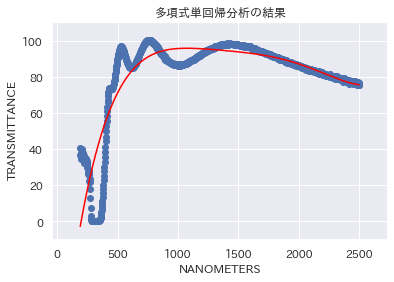

In [20]:
# 推定結果
beta0 = regpopt[1].intercept_[0]
print("β0 = {0:5.2f} ".format(beta0))
for idx in range(1,degopt+1):
    beta = regpopt[1].coef_[0][idx]
    print("β{0:d} = {1:5.2f} ".format(idx,beta))

# 回帰曲線をプロット
fig, ax = plt.subplots()
#xfit = np.linspace(minx,maxx,nSamples).reshape(-1,1)
yfit = regpopt.predict(xfit)
ax.scatter(x,y)
ax.plot(xfit,yfit, color = 'red')
ax.set_title("多項式単回帰分析の結果")
ax.set_xlabel(dataset.columns[0])
ax.set_ylabel(dataset.columns[1])
ax.set_xlim([minx-0.1*rx,maxx+0.1*rx])
ax.set_ylim([miny-0.1*ry,maxy+0.1*ry])
ax.grid(True)
plt.show()